#### By: Peyman Shahidi
#### Created: Oct 29, 2025
#### Last Edit: Oct 29, 2025

<br>

In [233]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [234]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects/ONET_BLS_matchedEmpShares'
output_plot_path = f"{main_folder_path}/writeup/plots/anthropic_AI_index/industry_weighted"

In [235]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [236]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Drop  columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [237]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")

# Keep relevant columns only
gpts_full_labels = gpts_full_labels[['O*NET-SOC Code', 'Task ID', 'Task', 'Task Type', 'Title', 'gpt4_exposure', 'human_labels']]

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")


gpts_full_labels.head(5)

Number of rows in GPTs full labels dataset: 19,265


,O*NET-SOC Code,Task ID,Task Title,Task Type,Occupation Title,gpt4_exposure,human_labels
0,11-1011.00,8823,Direct or coordinate an organizations financia...,Core,Chief Executives,E2,E0
1,11-1011.00,8831,Appoint department heads or managers and assig...,Core,Chief Executives,E0,E0
2,11-1011.00,8825,Analyze operations to evaluate performance of ...,Core,Chief Executives,E2,E2
3,11-1011.00,8826,"Direct, plan, or implement policies, objective...",Core,Chief Executives,E2,E0
4,11-1011.00,8827,"Prepare budgets for approval, including those ...",Core,Chief Executives,E2,E2


In [238]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 791


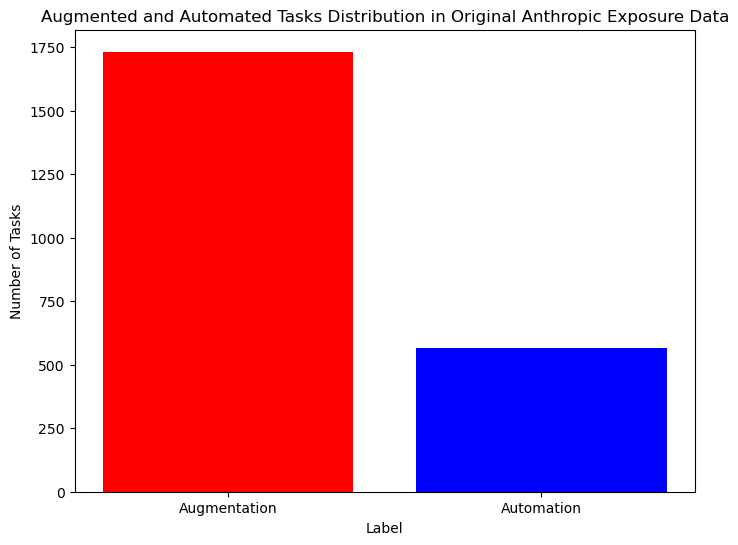

In [239]:
# Merge with Anthropic exposure data
anthropic_exposure = pd.read_csv(f'{input_data_path}/Anthropic_EconomicIndex/automation_vs_augmentation_by_task.csv')

# Remove if all entries are filtered:
anthropic_exposure = anthropic_exposure[anthropic_exposure['filtered'] != 1].reset_index(drop=True)

# Create new columns:
# Sum feedback loop and directive into Automation
# Sum validation, iteration, and learning into Augmentation
anthropic_exposure['automation'] = anthropic_exposure.apply(lambda row: row['feedback_loop'] + row['directive'], axis=1)
anthropic_exposure['augmentation'] = anthropic_exposure.apply(lambda row: row['validation'] + row['task_iteration'] + row['learning'], axis=1)

# Assign labels: take the max of automation, augmentation, manual and assign the corresponding label
def assign_label(row):
    max_value = max(row['automation'], row['augmentation'])
    if max_value == row['automation']:
        return 'Automation'
    elif max_value == row['augmentation']:
        return 'Augmentation'

anthropic_exposure['label'] = anthropic_exposure.apply(assign_label, axis=1)

# Filter to only keep the relevant columns
anthropic_exposure = anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']]

# Plot histogram of the label column to see share of each label
label_counts = anthropic_exposure['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color=['red', 'blue'])
plt.title('Augmented and Automated Tasks Distribution in Original Anthropic Exposure Data')
plt.xlabel('Label')
plt.ylabel('Number of Tasks')
# plt.savefig(f'{output_plot_path}/anthropicIndex_automatedAugmented_taskDist.png')
plt.show()

In [240]:
# Print number of unique tasks in ONET dataset
print(f"Number of unique tasks in ONET dataset: {ONET['Task Title'].nunique():,}")

# Print number of unique tasks in Anthropic exposure dataset
print(f"Number of unique tasks in Anthropic exposure dataset: {anthropic_exposure['task_name'].nunique():,}")


# Add normalized task title to ONET for merging
ONET["task_normalized"] = ONET["Task Title"].str.lower().str.strip()


# Merge ONET and Anthropic exposure data on the normalized task title
merged_data = pd.merge(ONET, anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']], left_on="task_normalized", right_on="task_name", how="left")

# Fill the NaN values of the label column in merged dataset as Manual
merged_data['label'] = merged_data['label'].fillna('Manual')

# Print distribution after filling NaN values
print(f"\nDistribution of labels after filling NaN values with 'Manual':")
print(merged_data['label'].value_counts())
print(f"Total tasks: {len(merged_data):,}")

merged_data.head()

Number of unique tasks in ONET dataset: 16,913
Number of unique tasks in Anthropic exposure dataset: 2,298

Distribution of labels after filling NaN values with 'Manual':
label
Manual          15605
Augmentation     1626
Automation        722
Name: count, dtype: int64
Total tasks: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_exposure,human_labels,task_normalized,task_name,automation,augmentation,label
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,NaN,NaN,direct or coordinate an organization's financi...,direct or coordinate an organization's financi...,0.35,0.57,Augmentation
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E0,E0,"confer with board members, organization offici...","confer with board members, organization offici...",0.25,0.61,Augmentation
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,analyze operations to evaluate performance of ...,analyze operations to evaluate performance of ...,0.31,0.66,Augmentation
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E0,"direct, plan, or implement policies, objective...",NaN,NaN,NaN,Manual
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,"prepare budgets for approval, including those ...",NaN,NaN,NaN,Manual


In [241]:
# # Drop the supplemental tasks
# merged_data = merged_data[merged_data['Task Type'] != 'Supplemental'].reset_index(drop=True)

# # Drop rows whose Occupation Title includes 'Teachers, Postsecondary'
# merged_data = merged_data[~merged_data['Occupation Title'].str.contains('Teachers, Postsecondary')].reset_index(drop=True)

In [242]:
# Keep relevant columns
cols = ['Detailed_Occupation_Code', 'Detailed_Occupation_Title',
        'Task ID', 'Task Title',
       'Task Type', 'Task_Time_Percentage', 'Hourly_Mean_Wage',
       'gpt4_exposure', 'human_labels',
       'automation', 'augmentation', 'label']
merged_data = merged_data[cols]
merged_data.head()

,Detailed_Occupation_Code,Detailed_Occupation_Title,Task ID,Task Title,Task Type,Task_Time_Percentage,Hourly_Mean_Wage,gpt4_exposure,human_labels,automation,augmentation,label
0,11-1011,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,9.62,124.47,NaN,NaN,0.35,0.57,Augmentation
1,11-1011,Chief Executives,8824,"Confer with board members, organization offici...",Core,9.49,124.47,E0,E0,0.25,0.61,Augmentation
2,11-1011,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,9.22,124.47,E2,E2,0.31,0.66,Augmentation
3,11-1011,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,10.26,124.47,E2,E0,NaN,NaN,Manual
4,11-1011,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,1.46,124.47,E2,E2,NaN,NaN,Manual


In [243]:
# Create occupation-level analysis for scatter plots
# Group by occupation and calculate label fractions and task counts
occupation_stats = []

for (soc_code, occ_title), group in merged_data.groupby(['Detailed_Occupation_Code', 'Detailed_Occupation_Title']):
    num_tasks = group['Task ID'].nunique()
    # num_occupations = group['Detailed_Occupation_Code'].nunique()
    total_tasks = len(group)
    
    manual_fraction = (group['label'] == 'Manual').sum() / total_tasks
    augmentation_fraction = (group['label'] == 'Augmentation').sum() / total_tasks  
    automation_fraction = (group['label'] == 'Automation').sum() / total_tasks
    ai_fraction = augmentation_fraction + automation_fraction
    gpt4_E0_fraction = (group['gpt4_exposure'] == 'E0').sum() / total_tasks
    gpt4_E1_fraction = (group['gpt4_exposure'] == 'E1').sum() / total_tasks
    gpt4_E2_fraction = (group['gpt4_exposure'] == 'E2').sum() / total_tasks
    gpt4_aiExposure_fraction = gpt4_E1_fraction + gpt4_E2_fraction
    human_E0_fraction = (group['human_labels'] == 'E0').sum() / total_tasks
    human_E1_fraction = (group['human_labels'] == 'E1').sum() / total_tasks
    human_E2_fraction = (group['human_labels'] == 'E2').sum() / total_tasks
    human_aiExposure_fraction = human_E1_fraction + human_E2_fraction

    
    occupation_stats.append({
        'Detailed_Occupation_Code': soc_code,
        'Detailed_Occupation_Title': occ_title,
        'num_tasks': num_tasks,
        # 'num_occupations': num_occupations,
        'manual_fraction': manual_fraction,
        'ai_fraction': ai_fraction,
        'augmentation_fraction': augmentation_fraction,
        'automation_fraction': automation_fraction,
        'gpt4_E0_fraction': gpt4_E0_fraction,
        'gpt4_E1_fraction': gpt4_E1_fraction,
        'gpt4_E2_fraction': gpt4_E2_fraction,
        'gpt4_aiExposure_fraction': gpt4_aiExposure_fraction,
        'human_E0_fraction': human_E0_fraction,
        'human_E1_fraction': human_E1_fraction,
        'human_E2_fraction': human_E2_fraction,
        'human_aiExposure_fraction': human_aiExposure_fraction
    })

occupation_analysis = pd.DataFrame(occupation_stats)

# save occupation analysis to CSV
occupation_analysis.to_csv(f'{output_data_path}/anthropic_detailedOccupationLevel_taskExposure_dataset.csv', index=False)

print(f"Number of occupations: {len(occupation_analysis):,}")
print(f"Range of tasks per occupation: {occupation_analysis['num_tasks'].min()} - {occupation_analysis['num_tasks'].max()}")
print(f"\nSample of occupation analysis:")
occupation_analysis.head(5)

Number of occupations: 759
Range of tasks per occupation: 4 - 173

Sample of occupation analysis:


,Detailed_Occupation_Code,Detailed_Occupation_Title,num_tasks,manual_fraction,ai_fraction,augmentation_fraction,automation_fraction,gpt4_E0_fraction,gpt4_E1_fraction,gpt4_E2_fraction,gpt4_aiExposure_fraction,human_E0_fraction,human_E1_fraction,human_E2_fraction,human_aiExposure_fraction
0,11-1011,Chief Executives,49,0.73,0.27,0.27,0.00,0.14,0.12,0.71,0.84,0.39,0.12,0.47,0.59
1,11-1021,General and Operations Managers,17,0.94,0.06,0.06,0.00,0.06,0.00,0.94,0.94,0.35,0.12,0.53,0.65
2,11-2011,Advertising and Promotions Managers,21,0.86,0.14,0.14,0.00,0.05,0.00,0.95,0.95,0.19,0.29,0.52,0.81
3,11-2021,Marketing Managers,20,0.70,0.30,0.30,0.00,0.05,0.05,0.90,0.95,0.05,0.25,0.70,0.95
4,11-2022,Sales Managers,17,0.82,0.18,0.18,0.00,0.12,0.00,0.88,0.88,0.12,0.12,0.76,0.88


In [244]:
# Merge industry employment share weights for all NAICS sectors and create a master dataset
bls_sector_shares = pd.read_csv(f'{input_data_path}/computed_objects/bls_sector_shares.csv')

# Drop rows whose industry employment share is NaN or 0
bls_sector_shares = bls_sector_shares.dropna(subset=['ind_emp_share'])
bls_sector_shares = bls_sector_shares[bls_sector_shares['ind_emp_share'] > 0].reset_index(drop=True)

# Ensure NAICS is string for consistent merging
bls_sector_shares['NAICS'] = bls_sector_shares['NAICS'].astype(str)

unique_sectors = bls_sector_shares['NAICS'].unique()
print(f"Found {len(unique_sectors)} unique NAICS sectors to process")

master_dfs = []
processed_sectors = []

for sector_code in unique_sectors:
    sector_weights_df = bls_sector_shares[bls_sector_shares.NAICS == sector_code]

    # Merge occupation-level analysis with this sector's weights
    sector_occupation_analysis = occupation_analysis.merge(
        sector_weights_df[['NAICS', 'NAICS_TITLE', 'OCC_CODE', 'TOT_EMP', 'ind_emp_share', 'total_emp_share']],
        left_on='Detailed_Occupation_Code',
        right_on='OCC_CODE',
        how='left'
    )

    # Drop rows without an industry employment share for this sector
    sector_occupation_analysis = sector_occupation_analysis.dropna(subset=['ind_emp_share']).reset_index(drop=True)

    if sector_occupation_analysis.empty:
        # Nothing matched for this sector; skip saving but log
        print(f"Sector {sector_code}: no matching occupations -> skipped")
        continue

    # Label the dataframe with the sector code and title for clarity
    sector_occupation_analysis['sector_code'] = sector_code
    if 'NAICS_TITLE' in sector_occupation_analysis.columns:
        sector_occupation_analysis['sector_title'] = sector_occupation_analysis['NAICS_TITLE']
    else:
        sector_occupation_analysis['sector_title'] = sector_code

    master_dfs.append(sector_occupation_analysis)
    processed_sectors.append(sector_code)

# Concatenate all sector-specific records into a master dataframe
if master_dfs:
    master_df = pd.concat(master_dfs, ignore_index=True)
else:
    master_df = pd.DataFrame()

print(f"Processed {len(processed_sectors)} sectors. Master dataset rows: {len(master_df):,}")

# Save per-sector CSVs and the master CSV
if not master_df.empty:
    for sec in sorted(master_df['sector_code'].unique()):
        df_sec = master_df[master_df['sector_code'] == sec].copy()
        out_path = f"{output_data_path}/detailedOccupationLevel_taskExposure_dataset_sector_{sec}.csv"
        df_sec.to_csv(out_path, index=False)

    master_out = f"{output_data_path}/detailedOccupationLevel_taskExposure_dataset_all_sectors.csv"
    master_df.to_csv(master_out, index=False)

    print(f"Saved {len(master_df['sector_code'].unique())} per-sector files and master file to: {output_data_path}")
else:
    print("No sector matches found; no files were saved.")

Found 20 unique NAICS sectors to process
Processed 20 sectors. Master dataset rows: 7,163
Saved 20 per-sector files and master file to: ../data/computed_objects/ONET_BLS_matchedEmpShares
Saved 20 per-sector files and master file to: ../data/computed_objects/ONET_BLS_matchedEmpShares


Found 20 unique NAICS sectors to plot
Sector 11 regression slope: 0.003124, intercept: -0.022411
Sector 21 regression slope: 0.000478, intercept: 0.023244
Sector 21 regression slope: 0.000478, intercept: 0.023244
Sector 22 regression slope: -0.000381, intercept: 0.071459
Sector 22 regression slope: -0.000381, intercept: 0.071459
Sector 23 regression slope: -0.002567, intercept: 0.112551
Sector 23 regression slope: -0.002567, intercept: 0.112551
Sector 31-33 regression slope: 0.000105, intercept: 0.045268
Sector 42 regression slope: -0.004211, intercept: 0.246928
Sector 31-33 regression slope: 0.000105, intercept: 0.045268
Sector 42 regression slope: -0.004211, intercept: 0.246928
Sector 44-45 regression slope: -0.005555, intercept: 0.276770
Sector 48-49 regression slope: -0.000522, intercept: 0.036481
Sector 44-45 regression slope: -0.005555, intercept: 0.276770
Sector 48-49 regression slope: -0.000522, intercept: 0.036481
Sector 51 regression slope: 0.000007, intercept: 0.190920
Secto

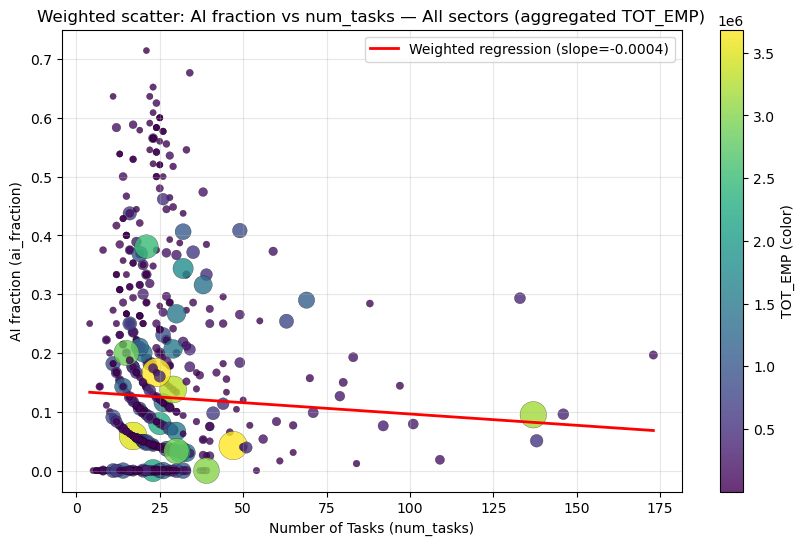

Master plot saved to: ../writeup/plots/anthropic_AI_index/industry_weighted/ai_fraction_vs_num_tasks_weighted_all_sectors.png


In [245]:
# Per-industry (NAICS) weighted scatter plots and a master plot combining all industries
# For each NAICS sector, use sector-specific TOT_EMP as weights; then create a master plot aggregating TOT_EMP across sectors.

bls_sector_shares = pd.read_csv(f'{input_data_path}/computed_objects/bls_sector_shares.csv')

# Basic checks
required_cols = {'NAICS', 'OCC_CODE', 'TOT_EMP'}
missing = required_cols - set(bls_sector_shares.columns)
if missing:
    raise KeyError(f"bls_sector_shares is missing required columns: {missing}")

# Normalize types
bls_sector_shares['NAICS'] = bls_sector_shares['NAICS'].astype(str)
bls_sector_shares['OCC_CODE'] = bls_sector_shares['OCC_CODE'].astype(str)

# Ensure occupation_analysis has string codes
occupation_analysis['Detailed_Occupation_Code'] = occupation_analysis['Detailed_Occupation_Code'].astype(str)

unique_sectors = bls_sector_shares['NAICS'].unique()
print(f"Found {len(unique_sectors)} unique NAICS sectors to plot")

processed = 0
skipped = []

for sector_code in sorted(unique_sectors):
    df_sec = bls_sector_shares[bls_sector_shares['NAICS'] == sector_code].copy()
    if df_sec.empty:
        skipped.append(sector_code)
        continue

    # Get a human-readable title if available
    sector_title = df_sec['NAICS_TITLE'].dropna().unique()
    if len(sector_title) > 0:
        sector_title = sector_title[0]
    else:
        sector_title = sector_code

    # Aggregate TOT_EMP by occupation within this sector
    occupation_emp_sec = (
        df_sec.groupby('OCC_CODE', as_index=False)['TOT_EMP']
        .sum()
        .rename(columns={'OCC_CODE': 'Detailed_Occupation_Code'})
    )

    merged = occupation_analysis.merge(occupation_emp_sec, on='Detailed_Occupation_Code', how='left')
    merged['TOT_EMP'] = merged['TOT_EMP'].fillna(0)
    plot_df = merged[merged['TOT_EMP'] > 0].copy()

    if plot_df.empty:
        skipped.append(sector_code)
        continue

    # Plotting
    max_emp = plot_df['TOT_EMP'].max()
    sizes = (plot_df['TOT_EMP'] / max_emp) * 400 + 20

    plt.figure(figsize=(10, 6))
    sc = plt.scatter(plot_df['num_tasks'], plot_df['ai_fraction'], s=sizes, c=plot_df['TOT_EMP'], cmap='plasma', alpha=0.8, edgecolor='k', linewidth=0.2)
    cbar = plt.colorbar(sc)
    cbar.set_label('TOT_EMP (color)')

    plt.xlabel('Number of Tasks (num_tasks)')
    plt.ylabel('AI fraction (ai_fraction)')
    safe_title = f"{sector_code} - {sector_title}"
    plt.title(f'Weighted scatter: AI fraction vs num_tasks — {safe_title}')

    # Weighted regression
    import numpy as np
    x = plot_df['num_tasks'].values
    y = plot_df['ai_fraction'].values
    w = plot_df['TOT_EMP'].values
    if len(np.unique(x)) > 1:
        coef = np.polyfit(x, y, deg=1, w=w)
        x_line = np.linspace(x.min(), x.max(), 200)
        y_line = np.polyval(coef, x_line)
        label_text = f"Weighted regression (slope={coef[0]:.4f})"
        plt.plot(x_line, y_line, color='red', linewidth=2, label=label_text)
        plt.legend()
        print(f"Sector {sector_code} regression slope: {coef[0]:.6f}, intercept: {coef[1]:.6f}")
    else:
        print(f"Sector {sector_code}: not enough variation in num_tasks to fit regression.")

    plt.grid(True, alpha=0.3)
    out_file = f"{output_plot_path}/ai_fraction_vs_num_tasks_weighted_sector_{sector_code}.png"
    plt.savefig(out_file, bbox_inches='tight', dpi=150)
    plt.close()

    processed += 1

print(f"Per-sector plotting complete. Processed: {processed}, Skipped (no matches): {len(skipped)}")

# --- Master plot: aggregate TOT_EMP across all sectors, then plot once (single regression) ---
occupation_emp_all = (
    bls_sector_shares.groupby('OCC_CODE', as_index=False)['TOT_EMP']
    .sum()
    .rename(columns={'OCC_CODE': 'Detailed_Occupation_Code'})
)

master_merged = occupation_analysis.merge(occupation_emp_all, on='Detailed_Occupation_Code', how='left')
master_merged['TOT_EMP'] = master_merged['TOT_EMP'].fillna(0)
master_plot_df = master_merged[master_merged['TOT_EMP'] > 0].copy()

if master_plot_df.empty:
    print('Master plot: no occupations with TOT_EMP > 0; skipping master plot.')
else:
    max_emp = master_plot_df['TOT_EMP'].max()
    sizes = (master_plot_df['TOT_EMP'] / max_emp) * 400 + 20

    plt.figure(figsize=(10, 6))
    sc = plt.scatter(master_plot_df['num_tasks'], master_plot_df['ai_fraction'], s=sizes, c=master_plot_df['TOT_EMP'], cmap='viridis', alpha=0.8, edgecolor='k', linewidth=0.2)
    cbar = plt.colorbar(sc)
    cbar.set_label('TOT_EMP (color)')

    plt.xlabel('Number of Tasks (num_tasks)')
    plt.ylabel('AI fraction (ai_fraction)')
    plt.title('Weighted scatter: AI fraction vs num_tasks — All sectors (aggregated TOT_EMP)')

    x = master_plot_df['num_tasks'].values
    y = master_plot_df['ai_fraction'].values
    w = master_plot_df['TOT_EMP'].values
    import numpy as np
    if len(np.unique(x)) > 1:
        coef = np.polyfit(x, y, deg=1, w=w)
        x_line = np.linspace(x.min(), x.max(), 200)
        y_line = np.polyval(coef, x_line)
        label_text = f"Weighted regression (slope={coef[0]:.4f})"
        plt.plot(x_line, y_line, color='red', linewidth=2, label=label_text)
        plt.legend()
        print(f"Master regression slope: {coef[0]:.6f}, intercept: {coef[1]:.6f}")
    else:
        print('Master plot: not enough variation in num_tasks to fit regression.')

    plt.grid(True, alpha=0.3)
    out_file = f"{output_plot_path}/ai_fraction_vs_num_tasks_weighted_all_sectors.png"
    plt.savefig(out_file, bbox_inches='tight', dpi=150)
    plt.show()
    print(f"Master plot saved to: {out_file}")

In [246]:
# Regressions: ai_fraction ~ num_tasks (unweighted), (weighted by TOT_EMP), and with sector fixed effects
# Uses the per-sector master dataset if available; otherwise rebuilds it from `bls_sector_shares` and `occupation_analysis`.

import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np

# Attempt to use `master_df` (per-sector occupation rows) if present
if 'master_df' in globals():
    df = master_df.copy()
    print('Using existing `master_df` from notebook state.')
else:
    print('`master_df` not found. Rebuilding master per-sector dataset from bls_sector_shares...')
    bls_sector_shares = pd.read_csv(f'{input_data_path}/computed_objects/bls_sector_shares.csv')
    bls_sector_shares['NAICS'] = bls_sector_shares['NAICS'].astype(str)
    bls_sector_shares['OCC_CODE'] = bls_sector_shares['OCC_CODE'].astype(str)

    rows = []
    for sector_code, grp in bls_sector_shares.groupby('NAICS'):
        if 'ind_emp_share' in grp.columns:
            grp_agg = grp.groupby('OCC_CODE', as_index=False)[['TOT_EMP','ind_emp_share']].sum()
        else:
            grp_agg = grp.groupby('OCC_CODE', as_index=False)[['TOT_EMP']].sum()
        grp_agg = grp_agg.rename(columns={'OCC_CODE': 'Detailed_Occupation_Code'})
        merged = occupation_analysis.merge(grp_agg, on='Detailed_Occupation_Code', how='left')
        merged['sector_code'] = sector_code
        rows.append(merged)
    if rows:
        df = pd.concat(rows, ignore_index=True)
    else:
        df = pd.DataFrame()

# Ensure required columns
if df.empty:
    raise ValueError('Master dataset is empty. Ensure earlier cells have produced `master_df` or bls_sector_shares is available.')

if 'ai_fraction' not in df.columns:
    raise KeyError('ai_fraction column not found in master dataset')

# Prepare regression DataFrame
cols_needed = ['ai_fraction', 'num_tasks', 'TOT_EMP', 'sector_code']
df_reg = df.copy()
for c in cols_needed:
    if c not in df_reg.columns:
        df_reg[c] = np.nan

# Drop rows missing the dependent or independent var
df_reg = df_reg[~df_reg['ai_fraction'].isna() & ~df_reg['num_tasks'].isna()].copy()

# Convert to numeric
df_reg['num_tasks'] = pd.to_numeric(df_reg['num_tasks'], errors='coerce')
df_reg['ai_fraction'] = pd.to_numeric(df_reg['ai_fraction'], errors='coerce')
df_reg['TOT_EMP'] = pd.to_numeric(df_reg.get('TOT_EMP', 0), errors='coerce').fillna(0)

# Drop any remaining NaNs in regression vars
df_reg = df_reg.dropna(subset=['num_tasks', 'ai_fraction'])

print(f'Regression sample size: {len(df_reg):,} rows')

# 1) OLS unweighted
model_ols = smf.ols('ai_fraction ~ num_tasks', data=df_reg).fit(cov_type='HC1')

# 2) WLS weighted by TOT_EMP (use positive TOT_EMP only)
df_w = df_reg[df_reg['TOT_EMP'] > 0].copy()
model_wls = None
if len(df_w) >= 2:
    model_wls = smf.wls('ai_fraction ~ num_tasks', data=df_w, weights=df_w['TOT_EMP']).fit(cov_type='HC1')
else:
    print('Not enough rows with positive TOT_EMP to run weighted regression; skipping WLS.')

# 3) OLS with sector fixed effects
model_fe = None
if 'sector_code' in df_reg.columns and df_reg['sector_code'].notna().any():
    df_fe = df_reg[~df_reg['sector_code'].isna()].copy()
    df_fe['sector_code'] = df_fe['sector_code'].astype(str)
    # If too many sectors (rare), statsmodels handles dummies automatically via C()
    model_fe = smf.ols('ai_fraction ~ num_tasks + C(sector_code)', data=df_fe).fit(cov_type='HC1')
else:
    print('sector_code not present or entirely NaN; skipping sector FE regression.')

# Build concise regression table for the coefficient on num_tasks
rows = []
rows.append({'model': 'OLS_unweighted', 'coef': model_ols.params.get('num_tasks', np.nan), 'se': model_ols.bse.get('num_tasks', np.nan), 't': model_ols.tvalues.get('num_tasks', np.nan), 'p': model_ols.pvalues.get('num_tasks', np.nan), 'n': int(model_ols.nobs)})
if model_wls is not None:
    rows.append({'model': 'WLS_weighted', 'coef': model_wls.params.get('num_tasks', np.nan), 'se': model_wls.bse.get('num_tasks', np.nan), 't': model_wls.tvalues.get('num_tasks', np.nan), 'p': model_wls.pvalues.get('num_tasks', np.nan), 'n': int(model_wls.nobs)})
else:
    rows.append({'model': 'WLS_weighted', 'coef': np.nan, 'se': np.nan, 't': np.nan, 'p': np.nan, 'n': 0})
if model_fe is not None:
    rows.append({'model': 'OLS_sectorFE', 'coef': model_fe.params.get('num_tasks', np.nan), 'se': model_fe.bse.get('num_tasks', np.nan), 't': model_fe.tvalues.get('num_tasks', np.nan), 'p': model_fe.pvalues.get('num_tasks', np.nan), 'n': int(model_fe.nobs)})
else:
    rows.append({'model': 'OLS_sectorFE', 'coef': np.nan, 'se': np.nan, 't': np.nan, 'p': np.nan, 'n': 0})

reg_table = pd.DataFrame(rows).set_index('model')
reg_table = reg_table[['coef', 'se', 't', 'p', 'n']]

# Nicely format and print
pd.options.display.float_format = '{:,.6f}'.format
print('\nRegression table (num_tasks coefficient):')
print(reg_table)

# Save the regression table
out_reg_table = f"{output_data_path}/regression_table_ai_fraction_num_tasks.csv"
reg_table.to_csv(out_reg_table)
print(f'Wrote regression table to: {out_reg_table}')

# Save full summaries to a text file for detail
summary_out = f"{output_data_path}/regression_summaries_ai_fraction_num_tasks.txt"
with open(summary_out, 'w') as fh:
    fh.write('=== OLS unweighted ===\n')
    fh.write(model_ols.summary().as_text())
    fh.write('\n\n')
    if model_wls is not None:
        fh.write('=== WLS weighted ===\n')
        fh.write(model_wls.summary().as_text())
        fh.write('\n\n')
    if model_fe is not None:
        fh.write('=== OLS with sector FE ===\n')
        fh.write(model_fe.summary().as_text())

print(f'Wrote regression model summaries to: {summary_out}')

Using existing `master_df` from notebook state.
Regression sample size: 7,163 rows

Regression table (num_tasks coefficient):
                    coef       se         t        p     n
model                                                     
OLS_unweighted  0.000229 0.000062  3.726777 0.000194  7163
WLS_weighted   -0.000041 0.000156 -0.266776 0.789642  7163
OLS_sectorFE    0.000211 0.000062  3.386075 0.000709  7163
Wrote regression table to: ../data/computed_objects/ONET_BLS_matchedEmpShares/regression_table_ai_fraction_num_tasks.csv
Wrote regression model summaries to: ../data/computed_objects/ONET_BLS_matchedEmpShares/regression_summaries_ai_fraction_num_tasks.txt


In [247]:
# Regressions for `human_aiExposure_fraction`: OLS, WLS (TOT_EMP), and sector fixed effects
# Mirrors the regression cell for ai_fraction but uses human_aiExposure_fraction as dependent variable

import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np

dep_var = 'human_aiExposure_fraction'
if dep_var not in occupation_analysis.columns and 'master_df' not in globals():
    raise KeyError(f"Dependent variable `{dep_var}` not found. Make sure `occupation_analysis` or `master_df` contains it.")

# Prefer using master_df if available
if 'master_df' in globals():
    df = master_df.copy()
    print('Using existing `master_df` for regressions.')
else:
    print('Rebuilding per-sector master_df for regressions...')
    bls_sector_shares = pd.read_csv(f'{input_data_path}/computed_objects/bls_sector_shares.csv')
    bls_sector_shares['NAICS'] = bls_sector_shares['NAICS'].astype(str)
    bls_sector_shares['OCC_CODE'] = bls_sector_shares['OCC_CODE'].astype(str)

    rows = []
    for sector_code, grp in bls_sector_shares.groupby('NAICS'):
        if 'ind_emp_share' in grp.columns:
            grp_agg = grp.groupby('OCC_CODE', as_index=False)[['TOT_EMP','ind_emp_share']].sum()
        else:
            grp_agg = grp.groupby('OCC_CODE', as_index=False)[['TOT_EMP']].sum()
        grp_agg = grp_agg.rename(columns={'OCC_CODE': 'Detailed_Occupation_Code'})
        merged = occupation_analysis.merge(grp_agg, on='Detailed_Occupation_Code', how='left')
        merged['sector_code'] = sector_code
        rows.append(merged)
    df = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

if df.empty:
    raise ValueError('Regression dataset is empty. Check earlier steps.')

if dep_var not in df.columns:
    raise KeyError(f"Dependent variable `{dep_var}` not found in regression dataset")

# Prepare regression DataFrame
cols_needed = [dep_var, 'num_tasks', 'TOT_EMP', 'sector_code']
df_reg = df.copy()
for c in cols_needed:
    if c not in df_reg.columns:
        df_reg[c] = np.nan

# Drop rows missing the dependent or independent var
df_reg = df_reg[~df_reg[dep_var].isna() & ~df_reg['num_tasks'].isna()].copy()

# Convert to numeric
df_reg['num_tasks'] = pd.to_numeric(df_reg['num_tasks'], errors='coerce')
df_reg[dep_var] = pd.to_numeric(df_reg[dep_var], errors='coerce')
df_reg['TOT_EMP'] = pd.to_numeric(df_reg.get('TOT_EMP', 0), errors='coerce').fillna(0)

# Drop any remaining NaNs in regression vars
df_reg = df_reg.dropna(subset=['num_tasks', dep_var])
print(f'Regression sample size for {dep_var}: {len(df_reg):,} rows')

# 1) OLS unweighted
model_ols = smf.ols(f'{dep_var} ~ num_tasks', data=df_reg).fit(cov_type='HC1')

# 2) WLS weighted by TOT_EMP (use positive TOT_EMP only)
df_w = df_reg[df_reg['TOT_EMP'] > 0].copy()
model_wls = None
if len(df_w) >= 2:
    model_wls = smf.wls(f'{dep_var} ~ num_tasks', data=df_w, weights=df_w['TOT_EMP']).fit(cov_type='HC1')
else:
    print('Not enough rows with positive TOT_EMP to run weighted regression; skipping WLS.')

# 3) OLS with sector fixed effects
model_fe = None
if 'sector_code' in df_reg.columns and df_reg['sector_code'].notna().any():
    df_fe = df_reg[~df_reg['sector_code'].isna()].copy()
    df_fe['sector_code'] = df_fe['sector_code'].astype(str)
    model_fe = smf.ols(f'{dep_var} ~ num_tasks + C(sector_code)', data=df_fe).fit(cov_type='HC1')
else:
    print('sector_code not present or entirely NaN; skipping sector FE regression.')

# Build concise regression table for the coefficient on num_tasks
rows = []
rows.append({'model': 'OLS_unweighted', 'coef': model_ols.params.get('num_tasks', np.nan), 'se': model_ols.bse.get('num_tasks', np.nan), 't': model_ols.tvalues.get('num_tasks', np.nan), 'p': model_ols.pvalues.get('num_tasks', np.nan), 'n': int(model_ols.nobs)})
if model_wls is not None:
    rows.append({'model': 'WLS_weighted', 'coef': model_wls.params.get('num_tasks', np.nan), 'se': model_wls.bse.get('num_tasks', np.nan), 't': model_wls.tvalues.get('num_tasks', np.nan), 'p': model_wls.pvalues.get('num_tasks', np.nan), 'n': int(model_wls.nobs)})
else:
    rows.append({'model': 'WLS_weighted', 'coef': np.nan, 'se': np.nan, 't': np.nan, 'p': np.nan, 'n': 0})
if model_fe is not None:
    rows.append({'model': 'OLS_sectorFE', 'coef': model_fe.params.get('num_tasks', np.nan), 'se': model_fe.bse.get('num_tasks', np.nan), 't': model_fe.tvalues.get('num_tasks', np.nan), 'p': model_fe.pvalues.get('num_tasks', np.nan), 'n': int(model_fe.nobs)})
else:
    rows.append({'model': 'OLS_sectorFE', 'coef': np.nan, 'se': np.nan, 't': np.nan, 'p': np.nan, 'n': 0})

reg_table = pd.DataFrame(rows).set_index('model')
reg_table = reg_table[['coef', 'se', 't', 'p', 'n']]

pd.options.display.float_format = '{:,.6f}'.format
print(f'\nRegression table ({dep_var} ~ num_tasks):')
print(reg_table)

# Save the regression table
out_reg_table = f"{output_data_path}/regression_table_{dep_var}_num_tasks.csv"
reg_table.to_csv(out_reg_table)
print(f'Wrote regression table to: {out_reg_table}')

# Save full summaries to a text file for detail
summary_out = f"{output_data_path}/regression_summaries_{dep_var}_num_tasks.txt"
with open(summary_out, 'w') as fh:
    fh.write(f'=== OLS unweighted ({dep_var}) ===\n')
    fh.write(model_ols.summary().as_text())
    fh.write('\n\n')
    if model_wls is not None:
        fh.write(f'=== WLS weighted ({dep_var}) ===\n')
        fh.write(model_wls.summary().as_text())
        fh.write('\n\n')
    if model_fe is not None:
        fh.write(f'=== OLS with sector FE ({dep_var}) ===\n')
        fh.write(model_fe.summary().as_text())

print(f'Wrote regression model summaries to: {summary_out}')

Using existing `master_df` for regressions.
Regression sample size for human_aiExposure_fraction: 7,163 rows

Regression table (human_aiExposure_fraction ~ num_tasks):
                   coef       se         t        p     n
model                                                    
OLS_unweighted 0.002142 0.000135 15.856919 0.000000  7163
WLS_weighted   0.000376 0.000517  0.727622 0.466845  7163
OLS_sectorFE   0.002061 0.000137 15.021016 0.000000  7163
Wrote regression table to: ../data/computed_objects/ONET_BLS_matchedEmpShares/regression_table_human_aiExposure_fraction_num_tasks.csv
Wrote regression model summaries to: ../data/computed_objects/ONET_BLS_matchedEmpShares/regression_summaries_human_aiExposure_fraction_num_tasks.txt


Found 20 unique NAICS sectors to plot for human_aiExposure_fraction
Sector 11 regression slope: -0.000490, intercept: 0.154540
Sector 21 regression slope: 0.008609, intercept: 0.040497
Sector 22 regression slope: -0.000582, intercept: 0.264154
Sector 23 regression slope: -0.009800, intercept: 0.495993
Sector 31-33 regression slope: 0.002533, intercept: 0.256597
Sector 42 regression slope: -0.015546, intercept: 0.934265
Sector 44-45 regression slope: -0.021547, intercept: 1.013057
Sector 48-49 regression slope: -0.010926, intercept: 0.563690
Sector 51 regression slope: 0.000618, intercept: 0.646215
Sector 52 regression slope: 0.000460, intercept: 0.678791
Sector 53 regression slope: -0.022746, intercept: 1.040363
Sector 54 regression slope: 0.000510, intercept: 0.746139
Sector 55 regression slope: 0.000757, intercept: 0.714888
Sector 56 regression slope: -0.003643, intercept: 0.305679
Sector 61 regression slope: -0.001922, intercept: 0.464217
Sector 62 regression slope: -0.000046, inter

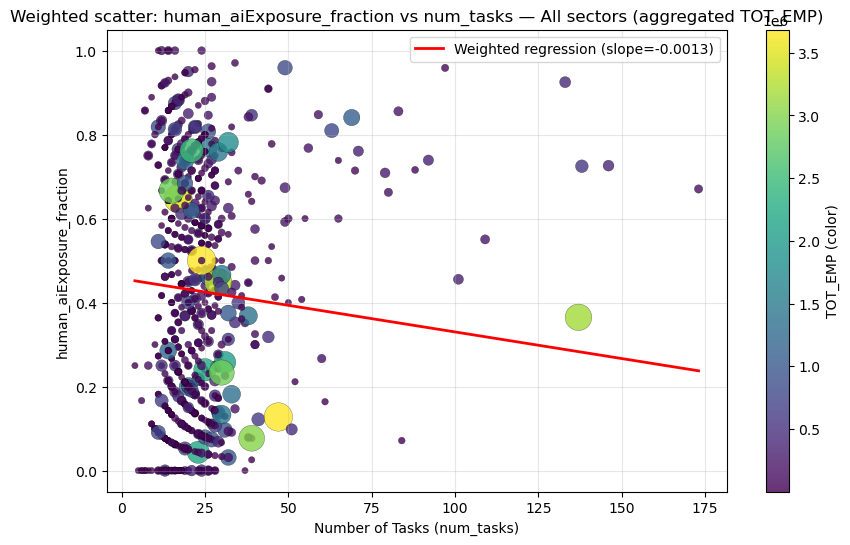

Master plot saved to: ../writeup/plots/anthropic_AI_index/industry_weighted/human_aiExposure_fraction_vs_num_tasks_weighted_all_sectors.png


In [248]:
# Per-industry and master weighted scatter plots for `human_aiExposure_fraction`
# Mirrors the ai_fraction plotting but for human_aiExposure_fraction

required_col = 'human_aiExposure_fraction'
if required_col not in occupation_analysis.columns:
    raise KeyError(f"Column `{required_col}` not found in `occupation_analysis`. Run previous cells to generate it.")

bls_sector_shares = pd.read_csv(f'{input_data_path}/computed_objects/bls_sector_shares.csv')
required_cols = {'NAICS', 'OCC_CODE', 'TOT_EMP'}
missing = required_cols - set(bls_sector_shares.columns)
if missing:
    raise KeyError(f"bls_sector_shares is missing required columns: {missing}")

bls_sector_shares['NAICS'] = bls_sector_shares['NAICS'].astype(str)
bls_sector_shares['OCC_CODE'] = bls_sector_shares['OCC_CODE'].astype(str)
occupation_analysis['Detailed_Occupation_Code'] = occupation_analysis['Detailed_Occupation_Code'].astype(str)

unique_sectors = bls_sector_shares['NAICS'].unique()
print(f"Found {len(unique_sectors)} unique NAICS sectors to plot for {required_col}")

processed = 0
skipped = []

for sector_code in sorted(unique_sectors):
    df_sec = bls_sector_shares[bls_sector_shares['NAICS'] == sector_code].copy()
    if df_sec.empty:
        skipped.append(sector_code)
        continue

    sector_title = df_sec['NAICS_TITLE'].dropna().unique()
    sector_title = sector_title[0] if len(sector_title) > 0 else sector_code

    occupation_emp_sec = (
        df_sec.groupby('OCC_CODE', as_index=False)['TOT_EMP']
        .sum()
        .rename(columns={'OCC_CODE': 'Detailed_Occupation_Code'})
    )

    merged = occupation_analysis.merge(occupation_emp_sec, on='Detailed_Occupation_Code', how='left')
    merged['TOT_EMP'] = merged['TOT_EMP'].fillna(0)
    merged = merged[~merged[required_col].isna()].copy()
    plot_df = merged[merged['TOT_EMP'] > 0].copy()

    if plot_df.empty:
        skipped.append(sector_code)
        continue

    max_emp = plot_df['TOT_EMP'].max()
    sizes = (plot_df['TOT_EMP'] / max_emp) * 400 + 20

    plt.figure(figsize=(10, 6))
    sc = plt.scatter(plot_df['num_tasks'], plot_df[required_col], s=sizes, c=plot_df['TOT_EMP'], cmap='plasma', alpha=0.8, edgecolor='k', linewidth=0.2)
    cbar = plt.colorbar(sc)
    cbar.set_label('TOT_EMP (color)')

    plt.xlabel('Number of Tasks (num_tasks)')
    plt.ylabel(f'{required_col}')
    safe_title = f"{sector_code} - {sector_title}"
    plt.title(f'Weighted scatter: {required_col} vs num_tasks — {safe_title}')

    import numpy as np
    x = plot_df['num_tasks'].values
    y = plot_df[required_col].values
    w = plot_df['TOT_EMP'].values
    if len(np.unique(x)) > 1:
        coef = np.polyfit(x, y, deg=1, w=w)
        x_line = np.linspace(x.min(), x.max(), 200)
        y_line = np.polyval(coef, x_line)
        label_text = f"Weighted regression (slope={coef[0]:.4f})"
        plt.plot(x_line, y_line, color='red', linewidth=2, label=label_text)
        plt.legend()
        print(f"Sector {sector_code} regression slope: {coef[0]:.6f}, intercept: {coef[1]:.6f}")
    else:
        print(f"Sector {sector_code}: not enough variation in num_tasks to fit regression.")

    plt.grid(True, alpha=0.3)
    out_file = f"{output_plot_path}/{required_col}_vs_num_tasks_weighted_sector_{sector_code}.png"
    plt.savefig(out_file, bbox_inches='tight', dpi=150)
    plt.close()

    processed += 1

print(f"Per-sector plotting complete for {required_col}. Processed: {processed}, Skipped (no matches): {len(skipped)}")

# Master plot (aggregate TOT_EMP across all sectors)
occupation_emp_all = (
    bls_sector_shares.groupby('OCC_CODE', as_index=False)['TOT_EMP']
    .sum()
    .rename(columns={'OCC_CODE': 'Detailed_Occupation_Code'})
)

master_merged = occupation_analysis.merge(occupation_emp_all, on='Detailed_Occupation_Code', how='left')
master_merged['TOT_EMP'] = master_merged['TOT_EMP'].fillna(0)
master_merged = master_merged[~master_merged[required_col].isna()].copy()
master_plot_df = master_merged[master_merged['TOT_EMP'] > 0].copy()

if master_plot_df.empty:
    print(f'Master plot: no occupations with TOT_EMP > 0 for {required_col}; skipping master plot.')
else:
    max_emp = master_plot_df['TOT_EMP'].max()
    sizes = (master_plot_df['TOT_EMP'] / max_emp) * 400 + 20

    plt.figure(figsize=(10, 6))
    sc = plt.scatter(master_plot_df['num_tasks'], master_plot_df[required_col], s=sizes, c=master_plot_df['TOT_EMP'], cmap='viridis', alpha=0.8, edgecolor='k', linewidth=0.2)
    cbar = plt.colorbar(sc)
    cbar.set_label('TOT_EMP (color)')

    plt.xlabel('Number of Tasks (num_tasks)')
    plt.ylabel(f'{required_col}')
    plt.title(f'Weighted scatter: {required_col} vs num_tasks — All sectors (aggregated TOT_EMP)')

    x = master_plot_df['num_tasks'].values
    y = master_plot_df[required_col].values
    w = master_plot_df['TOT_EMP'].values
    import numpy as np
    if len(np.unique(x)) > 1:
        coef = np.polyfit(x, y, deg=1, w=w)
        x_line = np.linspace(x.min(), x.max(), 200)
        y_line = np.polyval(coef, x_line)
        label_text = f"Weighted regression (slope={coef[0]:.4f})"
        plt.plot(x_line, y_line, color='red', linewidth=2, label=label_text)
        plt.legend()
        print(f"Master regression slope ({required_col}): {coef[0]:.6f}, intercept: {coef[1]:.6f}")
    else:
        print(f'Master plot: not enough variation in num_tasks to fit regression for {required_col}.')

    plt.grid(True, alpha=0.3)
    out_file = f"{output_plot_path}/{required_col}_vs_num_tasks_weighted_all_sectors.png"
    plt.savefig(out_file, bbox_inches='tight', dpi=150)
    plt.show()
    print(f"Master plot saved to: {out_file}")